In [1]:
from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader

# your path to data
train_path = r'/DATA/ichuviliaeva/ocr_data/train.lmdb'
test_path = r'/DATA/ichuviliaeva/ocr_data/test.lmdb'
gt_path = './gt.txt'

In [2]:
import cv2
import numpy as np
import torchvision
import wandb

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [4]:
train_helper, val_helper = train_helper.train_val_split()

In [5]:
train_helper.size(), val_helper.size()

(2578433, 644609)

In [6]:
import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn

class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper
    
    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        return torch.FloatTensor((cv2.resize(img, (32, 32)) - 127.5) / 255.)[None, ...], label

In [7]:
torch.manual_seed(42)

In [8]:
train_dataset = HWDBDataset(train_helper)
val_dataset = HWDBDataset(val_helper)

In [9]:
from task2pack.utils.train import show_train_plots, train_with_trainable_loss
from task2pack.models.resnet import ResNet18GrayscaleFeatPytorch
from task2pack.models.loss import CenterLoss

In [10]:
"""
model = ResNet34GrayscaleFeat(train_helper.vocabulary.num_classes())
"""
model = ResNet18GrayscaleFeatPytorch(train_helper.vocabulary.num_classes())

In [11]:
model_name = 'ResNet18GrayscaleFeatPytorch'

train_dataloader_config = {
    'batch_size': 512,
    'shuffle': True,
    'drop_last': True,
    'num_workers': 8,
}

test_dataloader_config = {
    'batch_size': 2048,
    'shuffle': False,
    'num_workers': 8,
}

training_config = {
    'lr': 1e-3,
    'epochs': 30,
    'milestones': [20, 50, 75],
    'gamma': 0.7,
    'weight_criterion': 0.5,
    'lr_criterion': 0.5,
}

device = 'cuda:2'
criterion = torch.nn.CrossEntropyLoss()
centerloss = CenterLoss(num_classes=train_helper.vocabulary.num_classes(), feat_dim=512)

wandb.init(
    project='ocr task 2',
    name='{} {} epochs with lr={} no augment'.format(model_name, training_config['epochs'], training_config['lr']),
    config={
        'train_dataloader_config': train_dataloader_config,
        'test_dataloader_config': test_dataloader_config,
        'training_config': training_config,

    "architecture": model_name,
    "dataset": "CASIA Offline Chinese Handwriting",
    "criterion": "Cross Entropy Loss + Centerloss",
    "optimizer": "Adam + SGD(Centerloss)",
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vashchilkoav. Use `wandb login --relogin` to force relogin


In [12]:
train_losses, test_losses, train_centerloss, test_centerloss, trained_model = train_with_trainable_loss(
    train_dataset=train_dataset,
    test_dataset=val_dataset,
    model=model, 
    criterion=criterion,
    trainable_criterion=centerloss,
    train_dataloader_kwargs=train_dataloader_config,
    test_dataloader_kwargs=test_dataloader_config,
    training_kwargs=training_config,
    device=device,
    wandb_instance=wandb,
    eval_every=2,
)

/home/avashchilko/abbyy10sem/course_ocr/task2/task2pack/models/loss.py:30: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  distmat.addmm_(1, -2, x, self.centers.t())


Initial val: [regular_loss: 0.004355111830815686, trainable_loss: 0.13525819649951135, accuracy: 8.066905674602744e-05]
Epoch 1:
Train loss: [regular: 0.012680103305972093 trainable: 0.25599788006044727]
Epoch 2:
Train loss: [regular: 0.0032812667295890998 trainable: 0.06638588139584557]
Val : [regular_loss: 0.0005400030978620402, trainable_loss: 0.009081145755491713, accuracy: 0.7524064975822553]
Epoch 3:
Train loss: [regular: 0.0018098082883493077 trainable: 0.023418160104847215]
Epoch 4:
Train loss: [regular: 0.0013880399385318978 trainable: 0.010122964959155887]
Val : [regular_loss: 0.0003051757260475859, trainable_loss: 0.001696495393416347, accuracy: 0.84620134065767]
Epoch 5:
Train loss: [regular: 0.0011411967463261466 trainable: 0.004919803025212289]
Epoch 6:
Train loss: [regular: 0.0010126460473842667 trainable: 0.0026196279175144353]
Val : [regular_loss: 0.0002823271188398364, trainable_loss: 0.0004975907710585161, accuracy: 0.8564432082083868]
Epoch 7:
Train loss: [regular: 

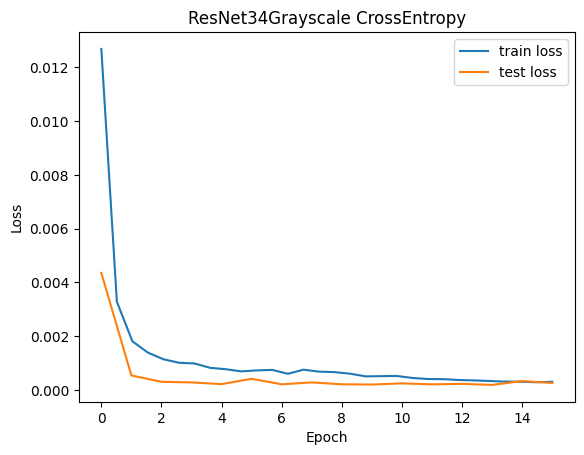

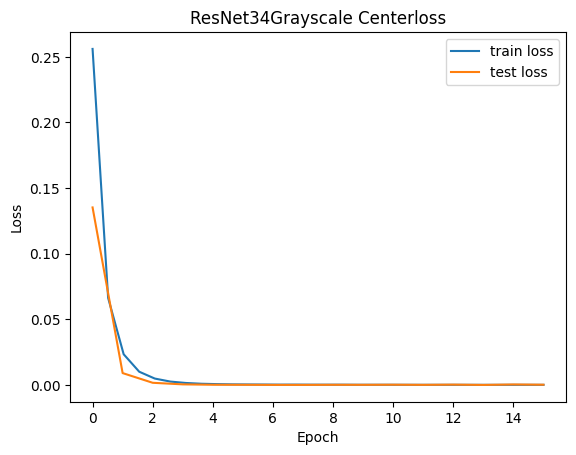

In [13]:
show_train_plots(train_losses, test_losses, 'ResNet34Grayscale CrossEntropy')
show_train_plots(train_centerloss, test_centerloss, 'ResNet34Grayscale Centerloss')

In [14]:
from course_ocr_t2.evaluate import evaluate
from tqdm import tqdm

test_path = r'/DATA/ichuviliaeva/ocr_data/test.lmdb'
pred_path = './pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=8)

preds = []
trained_model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        logits, _ = trained_model(X.to(torch.float32).to(device))
        classes = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(classes)
    
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)
        
test_accuracy = evaluate('./gt.txt', './pred.txt')
wandb.run.summary['test_accuracy'] = test_accuracy

torch.save(trained_model.state_dict(), './model.pth')
wandb.save('./model.pth')
wandb.save('./pred.txt')

wandb.finish()

100%|█████████████████████████████████████████████████████████████████████████████████| 380/380 [00:39<00:00,  9.65it/s]


lr,████████████████████▁▁▁▁▁▁▁▁▁▁
lr,0.0007
test_accuracy,0.84444
